In [67]:
import numpy as np

class bayesianAgent(object):
    neighbors = {}

    def __init__(self):
        pass

    def update_info(self):
        pass

    def spreading_process(self):
        pass


class bayesianUpdater(object):
    def __init__(self):
        pass

    def get_all_probas(self):
        pass

    def update_all_probas(self):
        pass


def markov_update(quantity, threshold, step, proba_decrease):
    rand1 = np.random.uniform()
    if rand1 > threshold:
        rand2 = np.random.uniform()
        if rand2 > proba_decrease:
            return min(1.0, quantity + step)
        else:
            return max(0.0, quantity - step)
    else:
        return quantity

class misinfoAgent(bayesianAgent):
    def __init__(
        self,
        agent_id,
        neighbors,
        forcefulness,
        share_propensity,
        misinfo_belief,
        trust_stability
    ):
        super().__init__()
        self.agent_id = agent_id
        self.neighbors = neighbors
        self.forcefulness = forcefulness
        self.share_propensity = share_propensity
        self.misinfo_belief = misinfo_belief
        self.trust_stability = trust_stability

    def update_info(self, neighbor_beliefs, neighbor_forcefulness):
        for n in self.neighbors.keys():
            self.neighbors[n] = markov_update(self.neighbors[n], self.trust_stability, 0.05, 0.5)
        beliefs = []
        trusts = []
        for tup, f in zip(neighbor_beliefs, neighbor_forcefulness):
            n, b = tup
            trusts.append(self.neighbors[n])
            beliefs.append(b * f)

        self.misinfo_belief = self.misinfo_belief * np.dot(trusts, beliefs)

        self.share_propensity = markov_update(self.share_propensity, self.trust_stability, 0.05, 0.8)
        
        


In [71]:
import random
import time

agents = []
n_agents = 500
for i in range(n_agents):
    if i % 50 == 0:
        print(i / n_agents)
    agent = misinfoAgent(
        agent_id=i, 
        neighbors={}, 
        forcefulness=random.choices([0.01, 0.9], weights=[20, 1])[0], 
        share_propensity=random.choices([0.01, 0.9], weights=[20, 1])[0],
        misinfo_belief=random.choices([0.1, 0.9], weights=[3, 1])[0], 
        trust_stability=np.random.uniform()
    )
    agents.append(agent)
    
p = 0.05
for i in range(n_agents):
    if i % 50 == 0:
        print(i / n_agents)
    for j in range(n_agents):
        draw = np.random.uniform()
        if draw < p:
            agents[i].neighbors[j] =  truncated_normal()
            agents[j].neighbors[i] =  truncated_normal()

agent_records = {a.agent_id: {} for a in agents}
shares = {a.agent_id: {} for a in agents}
for time_step in range(1000):
    if time_step % 10 == 0:
        print(time_step / 1000)
    for agent in agents:     
        agent_records[agent.agent_id][time_step] = {
            'neighbor_trust': agent.neighbors,
            'misinfo_belief': agent.misinfo_belief,
            'share_propensity': agent.share_propensity
        }
        neighbor_beliefs = [(i, agents[i].misinfo_belief) for i in agent.neighbors.keys()]
        neighbor_forcefulness = [agents[i].forcefulness for i in agent.neighbors.keys()]
        agent.update_info(neighbor_beliefs, neighbor_forcefulness)
        rand0 = np.random.uniform()
        if rand0 < agent.share_propensity * agent.misinfo_belief:
            shares[agent.agent_id][time_step] = True
        else:
            shares[agent.agent_id][time_step] = False


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
0.0


<ipython-input-67-225451bf5f3e>:66: RuntimeWarning: overflow encountered in double_scalars
  self.misinfo_belief = self.misinfo_belief * np.dot(trusts, beliefs)
<ipython-input-71-5a9d31b76c86>:44: RuntimeWarning: invalid value encountered in double_scalars
  if rand0 < agent.share_propensity * agent.misinfo_belief:


0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


(array([288.,  94.,  93.,   0.,  19.,   5.,   0.,   0.,   0.,   1.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

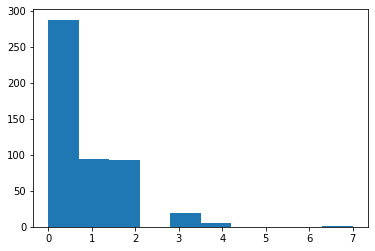

In [72]:
import matplotlib.pyplot as plt
share_counts = [np.sum([v for v in v.values()]) for v in shares.values()]
plt.hist(share_counts)

In [4]:
import scipy.stats
lower = 0
upper = 1
mu = 0.5
sigma = 0.1
N = 100000

def truncated_normal():
    return scipy.stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma)